In [1]:
!pip install ultralytics
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.4 MB/s eta 0:00:005.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 2.4 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.4/802.4 kB 2.1 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 1.5 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.3/174.3 kB 1.4 MB/s eta 0:00:001.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 1.2 MB/s eta 0:00:00m eta 0:00:010:00:020m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 1.4 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 1.3 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.0/201.0 kB 1.6 MB/s eta 0:00:001.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Dataset split summary (images/labels/missing/empty)

In [1]:
from pathlib import Path

DATASET_DIR = Path("dataset")
SPLITS = ["train", "valid", "test"]
IMG_EXTS = {".jpg", ".jpeg", ".png", ".webp", ".bmp"}

def split_summary(split: str):
    img_dir = DATASET_DIR / split / "images"
    lbl_dir = DATASET_DIR / split / "labels"

    imgs = [p for p in img_dir.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS]
    lbls = list(lbl_dir.glob("*.txt"))

    img_stems = {p.stem for p in imgs}
    lbl_stems = {p.stem for p in lbls}

    missing_labels = sorted(img_stems - lbl_stems)
    extra_labels   = sorted(lbl_stems - img_stems)

    empty_labels = []
    for lp in lbls:
        if lp.read_text(encoding="utf-8", errors="ignore").strip() == "":
            empty_labels.append(lp.name)

    return {
        "split": split,
        "images": len(imgs),
        "labels": len(lbls),
        "missing_labels": len(missing_labels),
        "extra_labels": len(extra_labels),
        "empty_label_files": len(empty_labels),
        "missing_label_names": missing_labels[:10],
        "extra_label_names": extra_labels[:10],
    }

rows = []
for s in SPLITS:
    if (DATASET_DIR / s).exists():
        rows.append(split_summary(s))

rows


[{'split': 'train',
  'images': 312,
  'labels': 312,
  'missing_labels': 0,
  'extra_labels': 0,
  'empty_label_files': 0,
  'missing_label_names': [],
  'extra_label_names': []},
 {'split': 'valid',
  'images': 39,
  'labels': 39,
  'missing_labels': 0,
  'extra_labels': 0,
  'empty_label_files': 0,
  'missing_label_names': [],
  'extra_label_names': []},
 {'split': 'test',
  'images': 39,
  'labels': 39,
  'missing_labels': 0,
  'extra_labels': 0,
  'empty_label_files': 0,
  'missing_label_names': [],
  'extra_label_names': []}]

### Boxes per split + per class

In [2]:
NUM_CLASSES = 13

def count_boxes_in_split(split: str, num_classes: int):
    lbl_dir = DATASET_DIR / split / "labels"
    boxes_per_class = [0] * num_classes
    total_boxes = 0
    bad_files = 0

    for lp in lbl_dir.glob("*.txt"):
        txt = lp.read_text(encoding="utf-8", errors="ignore").strip()
        if not txt:
            continue

        for line in txt.splitlines():
            parts = line.split()
            if len(parts) != 5:
                bad_files += 1
                continue
            try:
                cls = int(float(parts[0]))
            except:
                bad_files += 1
                continue

            if 0 <= cls < num_classes:
                boxes_per_class[cls] += 1
                total_boxes += 1

    return {
        "split": split,
        "total_boxes": total_boxes,
        "boxes_per_class": boxes_per_class,
        "bad_lines_or_files": bad_files
    }

box_stats = []
for s in SPLITS:
    if (DATASET_DIR / s).exists():
        box_stats.append(count_boxes_in_split(s, NUM_CLASSES))

box_stats


[{'split': 'train',
  'total_boxes': 436,
  'boxes_per_class': [18, 48, 56, 13, 49, 9, 46, 36, 48, 44, 11, 31, 27],
  'bad_lines_or_files': 0},
 {'split': 'valid',
  'total_boxes': 60,
  'boxes_per_class': [0, 9, 3, 0, 9, 2, 4, 4, 5, 8, 11, 3, 2],
  'bad_lines_or_files': 0},
 {'split': 'test',
  'total_boxes': 50,
  'boxes_per_class': [0, 9, 2, 1, 10, 0, 4, 1, 6, 5, 1, 3, 8],
  'bad_lines_or_files': 0}]

### Check same filenames exist in images + labels

In [3]:
def check_split(split):
    img_dir = Path("dataset") / split / "images"
    lbl_dir = Path("dataset") / split / "labels"
    imgs = {p.stem for p in img_dir.glob("*")}
    lbls = {p.stem for p in lbl_dir.glob("*.txt")}
    print(f"{split}: images={len(imgs)} labels={len(lbls)} missing_labels={len(imgs - lbls)}")

for s in ["train", "valid", "test"]:
    if (Path("dataset") / s).exists():
        check_split(s)


train: images=312 labels=312 missing_labels=0
valid: images=39 labels=39 missing_labels=0
test: images=39 labels=39 missing_labels=0


## Model Training

In [4]:
from ultralytics import YOLO

PRETRAINED_MODEL = "yolo11n.pt" 
model = YOLO(PRETRAINED_MODEL)

print("Selected pretrained model:", PRETRAINED_MODEL)


Selected pretrained model: yolo11n.pt


### Configure Epochs / Batch / Image Size

In [7]:
EPOCHS = 120
BATCH_SIZE = 16
IMG_SIZE = 640
RUN_NAME = "bdt_yolo11_train"
YAML_PATH = DATASET_DIR / "data.yaml"


### Fine-tune (Train) + Save Logs/Weights

In [9]:
train_results = model.train(
    data=str(YAML_PATH),
    epochs=EPOCHS,
    batch=BATCH_SIZE,
    imgsz=IMG_SIZE,
    project="runs",
    name=RUN_NAME
)

print("Training done!")
print("Logs + Weights saved in:", f"runs/detect/{RUN_NAME}/")


Ultralytics 8.3.248 🚀 Python-3.9.6 torch-2.8.0 CPU (Apple M1)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=120, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=bdt_yolo11_train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True,

### Evaluate on TEST set

In [16]:
metrics = model.val(
    data=str(YAML_PATH),
    split="test",
    imgsz=IMG_SIZE
)

metrics

Ultralytics 8.3.248 🚀 Python-3.9.6 torch-2.8.0 CPU (Apple M1)
YOLO11n summary (fused): 100 layers, 2,584,687 parameters, 15,015 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 204.6±129.3 MB/s, size: 8.6 KB)
val: Scanning /Users/hmmasumbillah/Documents/assignment 11/bd-currency-detection-yolo11/dataset/test/labels.cache... 39 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 39/39 106.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 1.8s/it 5.4s4.6ss
                   all         39         50      0.922      0.968      0.995      0.899
                1_taka          7          9       0.98          1      0.995       0.98
                2_taka          2          2      0.941          1      0.995      0.846
          2_takar_coin          1          1      0.967          1      0.995      0.597
                5_taka          8         10      0.989          1      0.995      0.975

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x1265df820>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046

### Report performance metrics

In [17]:
res = metrics.results_dict if hasattr(metrics, "results_dict") else None

print("Test Performance (key metrics):")
if res:
    for k, v in res.items():
        if isinstance(v, (int, float)):
            print(f"{k:25s} : {v:.4f}")
        else:
            print(f"{k:25s} : {v}")
else:
    print("Could not access results_dict; printing metrics object instead:")
    print(metrics)


Test Performance (key metrics):
metrics/precision(B)      : 0.9216
metrics/recall(B)         : 0.9682
metrics/mAP50(B)          : 0.9950
metrics/mAP50-95(B)       : 0.8992
fitness                   : 0.8992


### Detection results on test images

In [18]:
TEST_SOURCE = Path("dataset/test/images")
assert TEST_SOURCE.exists(), f"Test images folder missing: {TEST_SOURCE}"

CONF = 0.25
IOU = 0.7

pred = model.predict(
    source=str(TEST_SOURCE),
    imgsz=IMG_SIZE,
    conf=CONF,
    iou=IOU,
    save=True
)

pred


image 1/39 /Users/hmmasumbillah/Documents/assignment 11/bd-currency-detection-yolo11/dataset/test/images/1000_taka_12.jpeg: 640x576 2 1000_takas, 183.1ms
image 2/39 /Users/hmmasumbillah/Documents/assignment 11/bd-currency-detection-yolo11/dataset/test/images/1000_taka_20.jpeg: 608x640 2 1000_takas, 58.1ms
image 3/39 /Users/hmmasumbillah/Documents/assignment 11/bd-currency-detection-yolo11/dataset/test/images/1000_taka_21.jpeg: 352x640 1 200_taka, 1 1000_taka, 35.2ms
image 4/39 /Users/hmmasumbillah/Documents/assignment 11/bd-currency-detection-yolo11/dataset/test/images/1000_taka_23.jpeg: 352x640 1 100_taka, 1 1000_taka, 33.9ms
image 5/39 /Users/hmmasumbillah/Documents/assignment 11/bd-currency-detection-yolo11/dataset/test/images/1000_taka_24.jpeg: 352x640 1 100_taka, 32.1ms
image 6/39 /Users/hmmasumbillah/Documents/assignment 11/bd-currency-detection-yolo11/dataset/test/images/100_taka_25.jpeg: 320x640 1 100_taka, 30.3ms
image 7/39 /Users/hmmasumbillah/Documents/assignment 11/bd-curr

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: '1_takar_coin', 1: '1_taka', 2: '2_taka', 3: '2_takar_coin', 4: '5_taka', 5: '5_takar_coin', 6: '10_taka', 7: '20_taka', 8: '50_taka', 9: '100_taka', 10: '200_taka', 11: '500_taka', 12: '1000_taka'}
 obb: None
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
  

### Inference Result

Using prediction folder: /Users/hmmasumbillah/Documents/assignment 11/bd-currency-detection-yolo11/runs/detect/predict
Showing: 1_taka_15.jpg


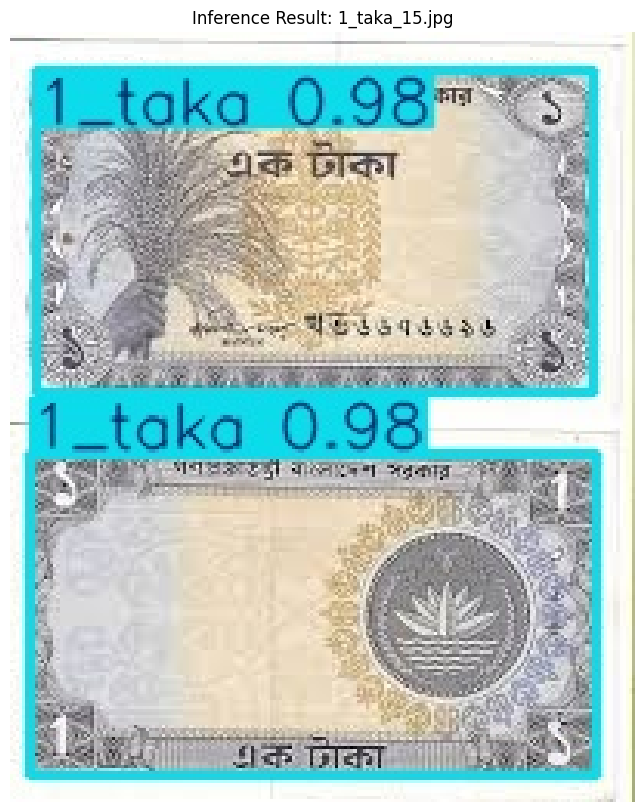

In [19]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image


detect_dir = Path(os.getcwd()) / "runs" / "detect"
pred_dirs = sorted(
    [p for p in detect_dir.glob("predict*") if p.is_dir()],
    key=lambda p: p.stat().st_mtime,
    reverse=True
)

if not pred_dirs:
    raise FileNotFoundError("No runs/detect/predict* folder found. Run model.predict(save=True) first.")

OUTPUT_DIR = pred_dirs[0]
print("Using prediction folder:", OUTPUT_DIR)

IMG_EXTS = {".jpg", ".jpeg", ".png", ".webp", ".bmp"}
images = [p for p in OUTPUT_DIR.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS]

if not images:
    raise FileNotFoundError(f"No image files found inside: {OUTPUT_DIR}")

inferred_image_path = random.choice(images)
print("Showing:", inferred_image_path.name)

img = Image.open(inferred_image_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.title(f"Inference Result: {inferred_image_path.name}")
plt.show()
